In [1]:
!pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c 'predict-energy-behavior-of-prosumers'

! mkdir data

! unzip /content/predict-energy-behavior-of-prosumers.zip -d data

Saving kaggle.json to kaggle.json
100% 233M/233M [00:10<00:00, 22.9MB/s]
100% 233M/233M [00:10<00:00, 22.7MB/s]
Archive:  /content/predict-energy-behavior-of-prosumers.zip
  inflating: data/client.csv         
  inflating: data/county_id_to_name_map.json  
  inflating: data/electricity_prices.csv  
  inflating: data/enefit/__init__.py  
  inflating: data/enefit/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: data/example_test_files/client.csv  
  inflating: data/example_test_files/electricity_prices.csv  
  inflating: data/example_test_files/forecast_weather.csv  
  inflating: data/example_test_files/gas_prices.csv  
  inflating: data/example_test_files/historical_weather.csv  
  inflating: data/example_test_files/revealed_targets.csv  
  inflating: data/example_test_files/sample_submission.csv  
  inflating: data/example_test_files/test.csv  
  inflating: data/forecast_weather.csv  
  inflating: data/gas_prices.csv     
  inflating: data/historical_weather.csv  
  inflating

In [2]:
!pip install --q neuralforecast==1.6.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00


In [3]:
!pip install -U polars==0.20.3 numpy==1.24.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.2
    Uninstalling polars-0.20.2:
      Successfully uninstalled polars-0.20.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [4]:
import numpy as np
import pandas as pd
import polars as pl
import holidays
import datetime
import warnings
import os
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast

# Data preparation

Follows: https://www.kaggle.com/code/greysky/enefit-darts-study-notes

In [5]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target):
    df_data = (
        df_data
        .join(df_target, on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
    )

    df_consume = (
        df_data
        .filter(pl.col("is_consumption").eq(1))
        .select("target", "county", "is_business", "product_type", "datetime")
    )

    df_data = (
        df_data
        .filter(pl.col("is_consumption").eq(0))
        .join(df_consume, on=["county", "is_business", "product_type", "datetime"], how="left")
        .rename({"target": "production", "target_right": "consumption"})
        .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        .drop("is_consumption")
    )

    df_client = (
        df_client
        .with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date))
    )

    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns((pl.col("date") + pl.duration(days=1)).cast(pl.Date))
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(datetime=pl.col("datetime") + pl.duration(days=1))
    )

    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )

    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
        .with_columns(pl.col("county").fill_nan(12))
        .group_by("county", "datetime").mean()
    )

    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        .join(df_forecast, on=["county", "datetime"], how="left")
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        .drop("date")
    )

    return df_data

In [6]:
def clean_interpolate_timeseries(df_data):

    # don't want this segment, most of the data is missing
    df_data = df_data.loc[
        ~(df_data[["county", "is_business", "product_type"]] == (12, 1, 3)).all(axis=1)
    ]

    chunks = []
    for (county, is_business, product_type), grp in df_data.groupby(
            ["county", "is_business", "product_type"]
    ):
        # interpolate missing values
        interpolated = (
            grp.sort_values(by="datetime")
            .set_index("datetime")
            .interpolate(method="time")
            .reset_index()
        )

        has_gaps = len(interpolated["datetime"].diff().value_counts()) != 1
        if has_gaps:
            # it is assumed that there will be no gaps between observations
            warnings.warn(
                f"{(is_business,product_type,county)=} has gaps in data (there are larger gaps than 1h in datetime column); skipping this series."
            )
            continue
        chunks.append(interpolated)
    df_train_interpolated = pd.concat(chunks).reset_index()

    return df_train_interpolated

In [7]:
class FeaturesGenerator:
    def __init__(self):
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features


    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "hour", "dayofyear"
        )
        return df_features

    def generate_features(self, df_features):

        for add_features in [
            self._add_general_features,
            self._add_holidays_features,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        return df_features

In [8]:
def to_pandas(df):
    df = df.to_pandas()
    df = df.set_index("row_id")

    return df

In [9]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"
root = "data"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime']

In [10]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)

df_target      = df_data.select(target_cols)
df_data        = df_data.drop("target")

df_data        = df_data.filter(pl.col("datetime").lt(pd.Timestamp("20230528")))
df_client      = df_client.filter(pl.col("date").lt(pd.Timestamp("20230526")))
df_gas         = df_gas.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_electricity = df_electricity.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_target      = df_target.filter(pl.col("datetime").lt(pd.Timestamp("20230526")))

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_target      = df_target.schema

In [11]:
feat_gen = FeaturesGenerator()

In [12]:
df_train = feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target)
df_train = feat_gen.generate_features(df_train)
df_train = clean_interpolate_timeseries(to_pandas(df_train))

df_train = df_train[df_train["consumption"].notnull()]
df_train = df_train[df_train["production"].notnull()]

In [13]:
# Remove old data
df_train = df_train[df_train["datetime"] >= pd.to_datetime("2022-11-03 00:00:00")]
df_train = df_train[df_train["datetime"] <= pd.to_datetime("2023-05-24 23:00:00")]

In [14]:
df_train.shape

(302064, 34)

In [15]:
df_train.columns

Index(['index', 'datetime', 'county', 'is_business', 'product_type',
       'production', 'consumption', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'eic_count', 'installed_capacity',
       'euros_per_mwh', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'day', 'weekday', 'month', 'year',
       'segment', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)',
       'is_country_holiday'],
      dtype='object')

In [16]:
df_train.isna().sum()

index                                0
datetime                             0
county                               0
is_business                          0
product_type                         0
production                           0
consumption                          0
lowest_price_per_mwh                 0
highest_price_per_mwh                0
eic_count                            0
installed_capacity                   0
euros_per_mwh                        0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
day                                  0
weekday                  

In [17]:
from neuralforecast.utils import HourOfDay, DayOfWeek, DayOfMonth, DayOfYear

# "dayhour","weekday", "monthday", "yearday"
hd = HourOfDay()
dw = DayOfWeek()
dm = DayOfMonth()
dy = DayOfYear()

df_train['dayhour'] = df_train['datetime'].apply(lambda x: hd(x))
df_train['weekday'] = df_train['datetime'].apply(lambda x: dw(x))
df_train['monthday'] = df_train['datetime'].apply(lambda x: dm(x))
df_train['yearday'] = df_train['datetime'].apply(lambda x: dy(x))

# We use these in range [-0.5,0.5] as absolute positional embeddings
df_train[["dayhour","weekday", "monthday", "yearday"]]

,dayhour,weekday,monthday,yearday
10272,-0.500000,0.000000,-0.433333,0.338356
10273,-0.456522,0.000000,-0.433333,0.338356
10274,-0.413043,0.000000,-0.433333,0.338356
10275,-0.369565,0.000000,-0.433333,0.338356
10276,-0.326087,0.000000,-0.433333,0.338356
...,...,...,...,...
929443,0.326087,-0.166667,0.266667,-0.108219
929444,0.369565,-0.166667,0.266667,-0.108219
929445,0.413043,-0.166667,0.266667,-0.108219
929446,0.456522,-0.166667,0.266667,-0.108219


In [18]:
static_df = df_train[["segment","county", "is_business", "product_type"]]
static_df = static_df.drop_duplicates()

# 2. Forecasting PRODUCTION

Follows: https://nixtlaverse.nixtla.io/neuralforecast/examples/longhorizon_with_transformers.html

In [19]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, VanillaTransformer

In [20]:
static = ["county", "is_business", "product_type"]
#past_covariates = ["consumption","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
#future_covariates = ["temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards"]
calendar_cols = ["dayhour", "weekday", "monthday", "yearday"]

Vanilla Transformer, Informer and Autoformer create absolute positional embeddings using calendar features. These need to be passed to the futr_exog_list.

In [25]:
output_size = 2*24 # 2 days ahead forecast
input_size = 7*24 # 7 days lookback window
max_steps=5000
models = [Informer(h=output_size,
                input_size=input_size,
                futr_exog_list=calendar_cols,
                val_check_steps=100,
                   max_steps=max_steps,
                early_stop_patience_steps=3),
          Autoformer(h=output_size,
                input_size=input_size,
                     max_steps=max_steps,
                futr_exog_list=calendar_cols,
                val_check_steps=100,
                early_stop_patience_steps=3),
          VanillaTransformer(h=output_size,
                input_size=input_size,
                             max_steps=max_steps,
                futr_exog_list=calendar_cols,
                val_check_steps=100,
                early_stop_patience_steps=3)
         ]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [23]:
n_time = len(df_train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time)

In [26]:
nf = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf.cross_validation(df=df_train.drop(columns=["county", "is_business", "product_type"]).rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None,
                               static_df=static_df.rename(columns={'segment':'unique_id'}))

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [27]:
Y_hat_df.head()

,unique_id,ds,cutoff,Informer,Autoformer,VanillaTransformer,index,y,consumption,lowest_price_per_mwh,...,month,year,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),is_country_holiday,dayhour,monthday,yearday
0,0_0_1,2023-05-14 21:00:00,2023-05-14 20:00:00,0.369077,728.570679,1.454116,14901,10.740,689.851013,38.599998,...,5,2023,0.745438,-0.666575,-0.707107,0.707107,False,0.413043,-0.066667,-0.135616
1,0_0_1,2023-05-14 22:00:00,2023-05-14 20:00:00,0.563048,726.879089,0.876740,14902,5.016,677.607971,38.599998,...,5,2023,0.745438,-0.666575,-0.500000,0.866025,False,0.456522,-0.066667,-0.135616
2,0_0_1,2023-05-14 23:00:00,2023-05-14 20:00:00,0.976188,752.935730,0.872461,14903,3.447,560.700989,38.599998,...,5,2023,0.745438,-0.666575,-0.258819,0.965926,False,0.500000,-0.066667,-0.135616
3,0_0_1,2023-05-15 00:00:00,2023-05-14 20:00:00,0.972602,799.362976,0.873370,14904,2.976,489.996002,37.509998,...,5,2023,0.733885,-0.679273,0.000000,1.000000,False,-0.500000,-0.033333,-0.132877
4,0_0_1,2023-05-15 01:00:00,2023-05-14 20:00:00,0.965808,863.447449,1.115541,14905,2.398,430.927002,37.509998,...,5,2023,0.733885,-0.679273,0.258819,0.965926,False,-0.456522,-0.033333,-0.132877


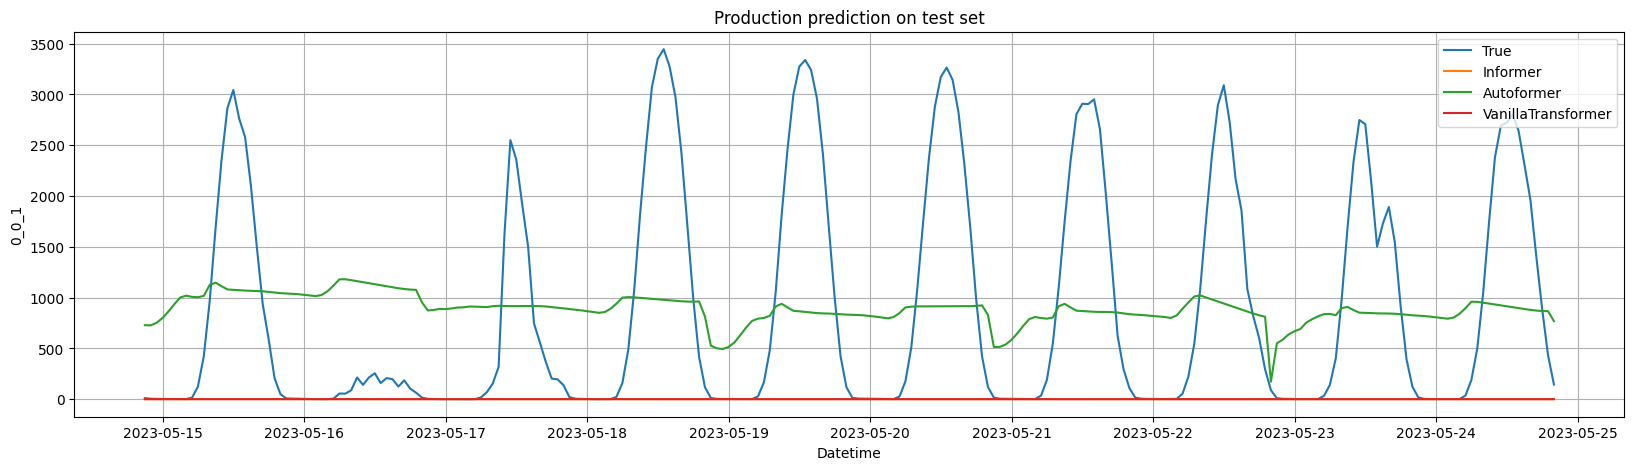

In [28]:
# Visualize forecasts on one segment
segment='0_0_1'
Y_plot = Y_hat_df[Y_hat_df['unique_id']==segment]
cutoffs = Y_hat_df['cutoff'].unique()[::output_size]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Production prediction on test set')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['Informer'], label='Informer')
plt.plot(Y_plot['ds'], Y_plot['Autoformer'], label='Autoformer')
plt.plot(Y_plot['ds'], Y_plot['VanillaTransformer'], label='VanillaTransformer')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('production_preds_example_b1.png')
plt.show()

In [29]:
# compare MAE
from neuralforecast.losses.numpy import mae
mae_informer = mae(Y_hat_df['y'], Y_hat_df['Informer'])
mae_autoformer = mae(Y_hat_df['y'], Y_hat_df['Autoformer'])
mae_vanilla = mae(Y_hat_df['y'], Y_hat_df['VanillaTransformer'])

In [30]:
print('Production MAE')
print('mae_informer', mae_informer)
print('mae_autoformer', mae_autoformer)
print('mae_vanilla',mae_vanilla)

Production MAE
mae_informer 363.04514
mae_autoformer 385.0909
mae_vanilla 362.92493


In [31]:
print('Test period:')
Y_plot['ds'].min(), Y_plot['ds'].max()

Test period:


(Timestamp('2023-05-14 21:00:00'), Timestamp('2023-05-24 20:00:00'))

In [32]:
mae_results = {
    'Model': ['VanillaTransformer', 'Informer', 'Autoformer'],
    'MAE_production': [mae_vanilla, mae_informer, mae_autoformer]
}

results_df = pd.DataFrame(mae_results)

results_df.sort_values('MAE_production')

,Model,MAE_production
0,VanillaTransformer,362.924927
1,Informer,363.045135
2,Autoformer,385.090912


In [33]:
nf.save(path='./checkpoints/production_model/',
        model_index=None,
        overwrite=True,
        save_dataset=True)

In [34]:
Y_hat_df.to_csv('production_predictions.csv')

# Forecasting consumption

In [35]:
nf_cons = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df_cons = nf_cons.cross_validation(df=df_train.drop(columns=["county", "is_business", "product_type"]).rename(columns={'datetime':'ds','consumption':'y','segment':'unique_id'}),
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None,
                               static_df=static_df.rename(columns={'segment':'unique_id'}))

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [36]:
Y_hat_df_cons.head()

,unique_id,ds,cutoff,Informer,Autoformer,VanillaTransformer,index,production,y,lowest_price_per_mwh,...,month,year,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),is_country_holiday,dayhour,monthday,yearday
0,0_0_1,2023-05-14 21:00:00,2023-05-14 20:00:00,0.937185,378.849121,1.368839,14901,10.740,689.851013,38.599998,...,5,2023,0.745438,-0.666575,-0.707107,0.707107,False,0.413043,-0.066667,-0.135616
1,0_0_1,2023-05-14 22:00:00,2023-05-14 20:00:00,0.977643,384.579620,2.844592,14902,5.016,677.607971,38.599998,...,5,2023,0.745438,-0.666575,-0.500000,0.866025,False,0.456522,-0.066667,-0.135616
2,0_0_1,2023-05-14 23:00:00,2023-05-14 20:00:00,1.010975,386.515167,2.173647,14903,3.447,560.700989,38.599998,...,5,2023,0.745438,-0.666575,-0.258819,0.965926,False,0.500000,-0.066667,-0.135616
3,0_0_1,2023-05-15 00:00:00,2023-05-14 20:00:00,0.984749,386.544952,2.112248,14904,2.976,489.996002,37.509998,...,5,2023,0.733885,-0.679273,0.000000,1.000000,False,-0.500000,-0.033333,-0.132877
4,0_0_1,2023-05-15 01:00:00,2023-05-14 20:00:00,0.992947,385.548798,2.112060,14905,2.398,430.927002,37.509998,...,5,2023,0.733885,-0.679273,0.258819,0.965926,False,-0.456522,-0.033333,-0.132877


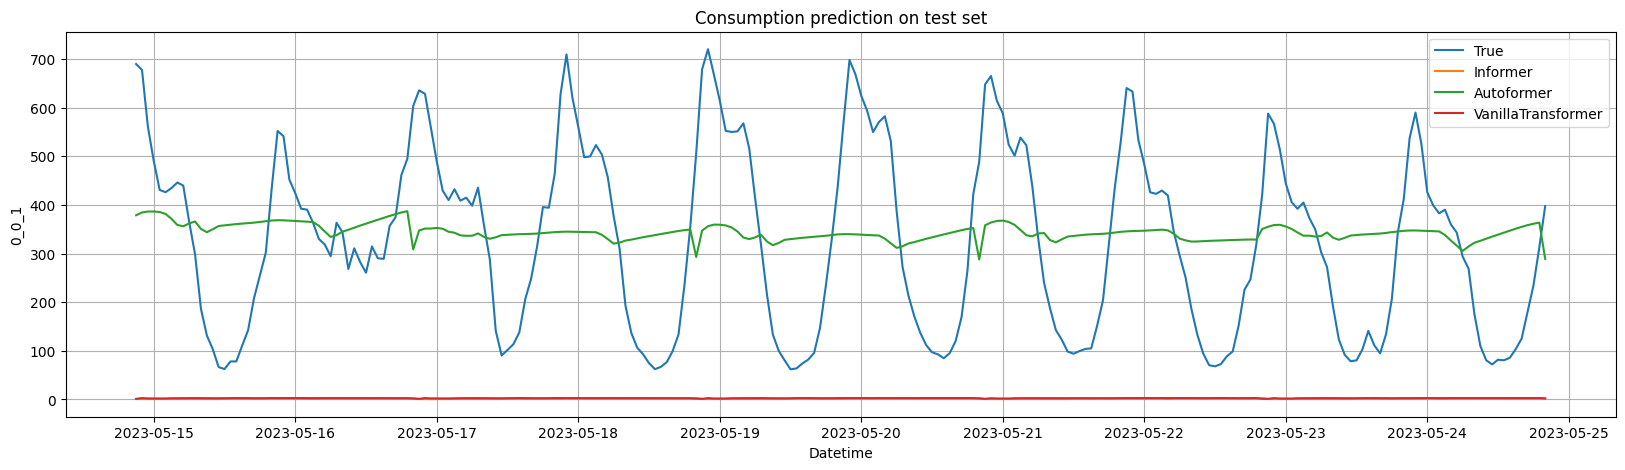

In [37]:
# Visualize forecasts on one segment
segment='0_0_1'
Y_plot = Y_hat_df_cons[Y_hat_df_cons['unique_id']==segment]
cutoffs = Y_hat_df_cons['cutoff'].unique()[::output_size]
Y_plot = Y_plot[Y_hat_df_cons['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Consumption prediction on test set')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['Informer'], label='Informer')
plt.plot(Y_plot['ds'], Y_plot['Autoformer'], label='Autoformer')
plt.plot(Y_plot['ds'], Y_plot['VanillaTransformer'], label='VanillaTransformer')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('consumption_preds_example_b1.png')
plt.show()

In [38]:
mae_informer = mae(Y_hat_df_cons['y'], Y_hat_df_cons['Informer'])
mae_autoformer = mae(Y_hat_df_cons['y'], Y_hat_df_cons['Autoformer'])
mae_vanilla = mae(Y_hat_df_cons['y'], Y_hat_df_cons['VanillaTransformer'])

In [39]:
print('Consumption MAE')
print('mae_informer', mae_informer)
print('mae_autoformer', mae_autoformer)
print('mae_vanilla',mae_vanilla)

Consumption MAE
mae_informer 398.2327
mae_autoformer 120.56416
mae_vanilla 397.36465


In [40]:
print('Test period:')
Y_plot['ds'].min(), Y_plot['ds'].max()

Test period:


(Timestamp('2023-05-14 21:00:00'), Timestamp('2023-05-24 20:00:00'))

In [41]:
mae_results = {
    'Model': ['VanillaTransformer', 'Informer', 'Autoformer'],
    'MAE_consumption': [mae_vanilla, mae_informer, mae_autoformer]
}

results_df_cons = pd.DataFrame(mae_results)

results_df_cons.sort_values('MAE_consumption')

,Model,MAE_consumption
2,Autoformer,120.564163
0,VanillaTransformer,397.364655
1,Informer,398.232697


In [42]:
results_df_merged = results_df.merge(results_df_cons, on='Model')
results_df_merged['overall_MAE'] = (results_df_merged['MAE_production'] + results_df_merged['MAE_consumption']) / 2
results_df_merged.sort_values('overall_MAE')

,Model,MAE_production,MAE_consumption,overall_MAE
2,Autoformer,385.090912,120.564163,252.827545
0,VanillaTransformer,362.924927,397.364655,380.144775
1,Informer,363.045135,398.232697,380.638916


In [43]:
print(results_df_merged)

                Model  MAE_production  MAE_consumption  overall_MAE
0  VanillaTransformer      362.924927       397.364655   380.144775
1            Informer      363.045135       398.232697   380.638916
2          Autoformer      385.090912       120.564163   252.827545


In [44]:
results_df_merged.to_csv('results_df_merged_informer_autoformer_vanilla.csv')

In [45]:
nf_cons.save(path='./checkpoints/consumption_model/',
        model_index=None,
        overwrite=True,
        save_dataset=True)

# Ensamble

In [46]:
Y_hat_df['models_mean'] = Y_hat_df[['VanillaTransformer', 'Informer', 'Autoformer']].mean(axis=1)

In [47]:
mae_models_mean = mae(Y_hat_df['y'], Y_hat_df['models_mean'])

In [49]:
Y_hat_df_cons['models_mean'] = Y_hat_df_cons[['VanillaTransformer', 'Informer', 'Autoformer']].mean(axis=1)

In [51]:
mae_models_mean_cons = mae(Y_hat_df_cons['y'], Y_hat_df_cons['models_mean'])

In [55]:
mae_ensamble = {
    'Model': ['Vanilla+Informer+Autoformer'],
    'MAE_production': [mae_models_mean],
    'MAE_consumption': [mae_models_mean_cons],
    'MAE_overall': [(mae_models_mean + mae_models_mean_cons) / 2]
}

mae_ensamble_df = pd.DataFrame(mae_ensamble)

print(mae_ensamble_df)

                         Model  MAE_production  MAE_consumption  MAE_overall
0  Vanilla+Informer+Autoformer      347.650757       271.857239   309.753998
